# POST PROCESSING FILE

In [119]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPolygon
from shapely.ops import nearest_points
from shapely.geometry import shape
from shapely.geometry import LineString
import searoute as sr
import numpy as np
import geojson
import json
from tqdm import tqdm
from pprint import pprint
pd.set_option('display.max_columns', None)

In [120]:
def plot_vessel_positions(df, land_file='ne_10m_land.zip'):
    # Create geometry column from longitude and latitude
    geometry = [Point(xy) for xy in zip(df['longitude_predicted'], df['latitude_predicted'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    # Load world map data from the Natural Earth file
    world = gpd.read_file(land_file)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the world map
    world.plot(ax=ax, alpha=0.5, color='lightgray')
    
    # Generate unique colors for each vessel
    unique_vessels = df['vesselId'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_vessels)))
    
    # Plot each vessel's points with a unique color and black edge
    for vessel, color in zip(unique_vessels, colors):
        vessel_data = gdf[gdf['vesselId'] == vessel]
        vessel_data.plot(ax=ax, marker='o', color=color, markersize=20, alpha=0.7,
                        edgecolor='black', linewidth=1)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.axis('off')  # Remove all axes
    
    return fig, ax

In [121]:
# LOAD
df = pd.read_csv('results_2.3.csv', sep=',')

test = pd.read_csv('ais_test.csv', sep=',')
test = test.drop(columns=['scaling_factor'])  # Remove time column from test
show = pd.merge(df, test, on='ID', how='left')
show['time'] = pd.to_datetime(show['time'])
show.head()

,ID,longitude_predicted,latitude_predicted,vesselId,time
0,0,-80.941090,31.264187,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16
1,1,119.937454,15.943081,61e9f473b937134a3c4c02df,2024-05-08 00:06:17
2,2,10.746855,38.867760,61e9f469b937134a3c4c029b,2024-05-08 00:10:02
3,3,172.998430,-43.347828,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34
4,4,-5.669545,48.539047,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27


KeyboardInterrupt: 

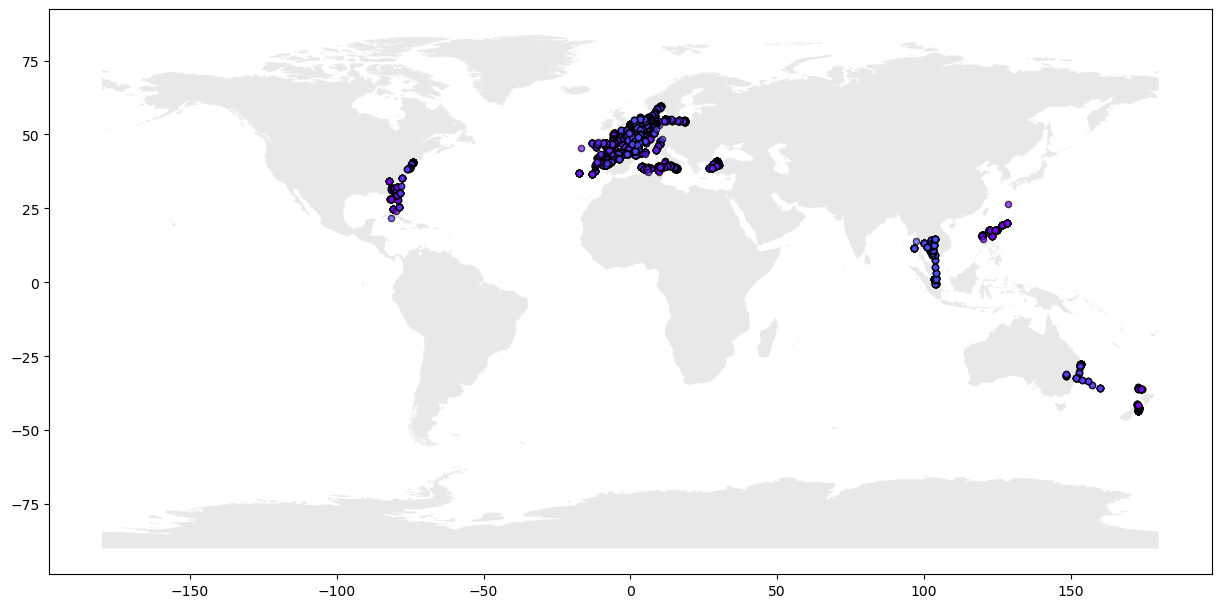

In [122]:
fig, ax = plot_vessel_positions(show)
plt.show()

In [123]:
land_world = gpd.read_file('ne_10m_land/ne_10m_land.shp').to_crs(4326)
ocean_world = gpd.read_file('ne_10m_ocean/ne_10m_ocean.shp').to_crs(4326)
gdf = gpd.GeoDataFrame(show, geometry=gpd.points_from_xy(df['longitude_predicted'], df['latitude_predicted'], crs="EPSG:4326"))
gdf.head()

,ID,longitude_predicted,latitude_predicted,vesselId,time,geometry
0,0,-80.941090,31.264187,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,POINT (-80.94109 31.26419)
1,1,119.937454,15.943081,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,POINT (119.93745 15.94308)
2,2,10.746855,38.867760,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,POINT (10.74686 38.86776)
3,3,172.998430,-43.347828,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,POINT (172.99843 -43.34783)
4,4,-5.669545,48.539047,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,POINT (-5.66955 48.53905)


In [124]:
# Check if point is on land
points_on_land = gpd.sjoin(gdf, land_world, how="inner", predicate="within")

In [125]:
show = show.sort_values(by='time')
# Group by 'vesselId' and create 'origin' and 'destination' directly as lists of [longitude, latitude]
first_last_positions = show.groupby('vesselId').agg(
    origin_longitude=('longitude_predicted', 'first'),
    origin_latitude=('latitude_predicted', 'first'),
    destination_longitude=('longitude_predicted', 'last'),
    destination_latitude=('latitude_predicted', 'last')
).reset_index()

# Create the 'origin' and 'destination' columns as lists of [longitude, latitude]
first_last_positions['origin'] = first_last_positions.apply(
    lambda row: [row['origin_longitude'], row['origin_latitude']], axis=1
)
first_last_positions['destination'] = first_last_positions.apply(
    lambda row: [row['destination_longitude'], row['destination_latitude']], axis=1
)
first_last_positions.head()

,vesselId,origin_longitude,origin_latitude,destination_longitude,destination_latitude,origin,destination
0,61e9f38eb937134a3c4bfd8d,-5.669545,48.539047,-8.874157,40.262436,"[-5.669545, 48.539047]","[-8.874157, 40.262436]"
1,61e9f399b937134a3c4bfdb7,-3.194327,51.381294,-12.390759,40.442722,"[-3.194327, 51.381294]","[-12.3907585, 40.442722]"
2,61e9f39ab937134a3c4bfdbb,116.498375,6.209050,118.694790,12.214645,"[116.498375, 6.20905]","[118.69479, 12.214645]"
3,61e9f39db937134a3c4bfdc5,-120.926880,34.223404,-114.241200,30.408604,"[-120.92688, 34.223404]","[-114.2412, 30.408604]"
4,61e9f39eb937134a3c4bfdcb,8.526235,53.704240,-15.646426,28.357275,"[8.526235, 53.70424]","[-15.646426, 28.357275]"


In [135]:
first_last_positions.dtypes

vesselId                  object
origin_longitude         float64
origin_latitude          float64
destination_longitude    float64
destination_latitude     float64
origin                    object
destination               object
dtype: object

In [155]:
searoutes = []
for _, row in first_last_positions.iterrows():
    vessel_id = row['vesselId']
    origin = row['origin']
    destination = row['destination']

    # Get the searoute (GeoJSON LineString) for the current vessel
    route_geojson = sr.searoute(origin, destination)
    
    ng_coordinates = route_geojson["geometry"]["coordinates"]

    if len(ng_coordinates) == 1:
        # It's a single coordinate, store it as a Point
        geometry = Point(ng_coordinates[0])
    else:
        # It's a LineString, store it as a LineString
        geometry = LineString(ng_coordinates)

    # Store the route geometry and vesselId in a dictionary
    searoutes.append({
        'vesselId': vessel_id,
        'route': geometry
    })

# Create the GeoDataFrame with the LineString geometry
searoutes_gdf = gpd.GeoDataFrame(searoutes, geometry='route')
searoutes_gdf.head()

,vesselId,route
0,61e9f38eb937134a3c4bfd8d,"LINESTRING (-5.74605 48.58137, -5.79747 48.520..."
1,61e9f399b937134a3c4bfdb7,"LINESTRING (-3.12372 51.39736, -3.26019 51.322..."
2,61e9f39ab937134a3c4bfdbb,"LINESTRING (116.84474 7.12273, 117.04681 7.039..."
3,61e9f39db937134a3c4bfdc5,"LINESTRING (-120.90000 34.30000, -120.67071 33..."
4,61e9f39eb937134a3c4bfdcb,"LINESTRING (8.53671 53.55888, 8.25000 53.90000..."


In [154]:
searoutes_gdf.to_csv('jsoncheck.csv')

In [ ]:
def adjust_to_route(row, searoutes_gdf):
    vessel_id = row['vesselId']
    predicted_point = row['geometry']
    
    # Get the corresponding route (LineString) for the vesselId
    route = searoutes_gdf[searoutes_gdf['vesselId'] == vessel_id]['route'].values[0]
    
    # Find the nearest point on the route (LineString) to the predicted point
    nearest_geom = nearest_points(predicted_point, route)[1]
    
    # Update the predicted latitude and longitude with the coordinates of the nearest point
    row['longitude_predicted'] = nearest_geom.x
    row['latitude_predicted'] = nearest_geom.y
    return row

gdf = gdf.apply(adjust_to_route, axis=1, searoutes_gdf=searoutes_gdf)

In [ ]:
gdf.drop 

,ID,longitude_predicted,latitude_predicted,vesselId,time,geometry
0,0,-81.118446,30.937150,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,POINT (-80.94109 31.26419)
1,1,119.400000,17.000000,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,POINT (119.93745 15.94308)
2,2,11.028974,38.861757,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,POINT (10.74686 38.86776)
3,3,173.405761,-43.755971,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,POINT (172.99843 -43.34783)
4,4,-5.746051,48.581371,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,POINT (-5.66955 48.53905)
